In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/8_DL/energydata_complete.csv', index_col = 'date', parse_dates = True)
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [5]:
df.shape

(19735, 28)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

<AxesSubplot:xlabel='date'>

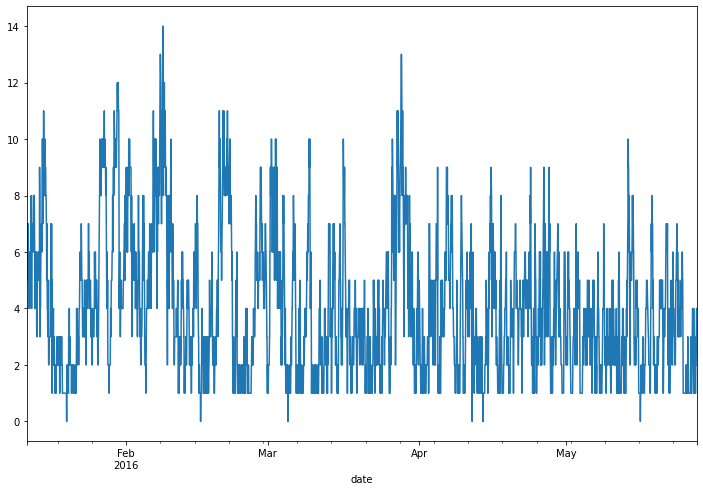

In [7]:
df['Windspeed'].plot(figsize = (12,8))

<AxesSubplot:xlabel='date'>

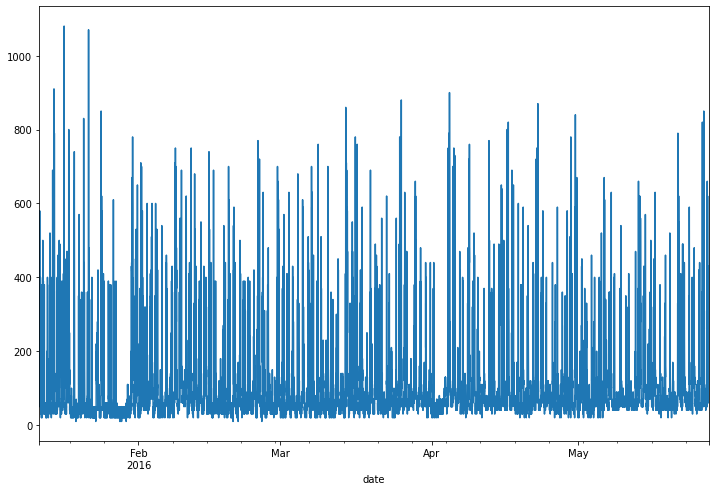

In [8]:
df['Appliances'].plot(figsize = (12,8))

# train/test split

In [9]:
df.shape

(19735, 28)

In [10]:
# 하루에 데이터가 몇 줄인가?
DATE_FREQ = 10
DAY_HOUR = 24
DAY_MIN = 60

DAY_ROW_COUNT = int(DAY_HOUR * DAY_MIN / DATE_FREQ)
DAY_ROW_COUNT

144

In [11]:
TEST_DAYS = 5

In [12]:
SPLIT_IDX = int(DAY_ROW_COUNT * TEST_DAYS)

In [13]:
train = df.iloc[:-SPLIT_IDX]
test = df.iloc[-SPLIT_IDX:]

print(train.shape)
print(test.shape)

(19015, 28)
(720, 28)


# scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
import tensorflow as tf
window_size = DAY_ROW_COUNT
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length = window_size, batch_size = 1)

In [16]:
len(generator)

18871

In [17]:
X, y = generator[0]
print(X.flatten())
print(y.flatten())

[0.04672897 0.42857143 0.32734952 ... 0.41176471 0.25810488 0.25810488]
[0.04672897 0.         0.34600493 0.4350977  0.21080688 0.61734507
 0.21518777 0.74466428 0.37477477 0.63593683 0.21691352 0.31703589
 0.35574637 0.76737445 0.25908472 0.5214736  0.20994812 0.55483208
 0.22996878 0.58333333 0.36977492 0.34651163 0.67105263 0.5
 0.43076923 0.40271493 0.72933144 0.72933144]


# modeling

In [18]:
window_size

144

In [19]:
n_features = scaled_train.shape[1]

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(100, input_shape = (window_size, n_features))) # , activation = 'relu' (생략가능)
model.add(Dense(n_features))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               51600     
                                                                 
 dense_1 (Dense)             (None, 28)                2828      
                                                                 
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


In [23]:
validation_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_test, scaled_test, length = window_size, batch_size = 1)

In [ ]:
model.fit(generator, epochs = 10, validation_data = validation_generator) # 곱셈연산이 많아서.. GRU써야돼..!!!

Epoch 1/10
18871/18871 [==============================] - 173s 9ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 2/10
18871/18871 [==============================] - 164s 9ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 3/10
18871/18871 [==============================] - 161s 9ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 4/10
 3725/18871 [====>.........................] - ETA: 2:07 - loss: 0.0067

In [21]:

# modeling
# 평가(predict)